In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import anomaly_tpp as tpp

from tqdm.auto import tqdm, trange
from statsmodels.distributions.empirical_distribution import ECDF

sns.set_style('whitegrid')
%matplotlib inline

In [11]:
num_sequences = 1000
t_max = 100
scenarios = [
    tpp.scenarios.spp.IncreasingRate(t_max),
    tpp.scenarios.spp.DecreasingRate(t_max),
    tpp.scenarios.spp.InhomogeneousPoisson(t_max),
    tpp.scenarios.spp.RenewalUp(t_max),
    tpp.scenarios.spp.RenewalDown(t_max),
    tpp.scenarios.spp.Hawkes(t_max),
    tpp.scenarios.spp.SelfCorrecting(t_max),
    tpp.scenarios.spp.Stopping(t_max),
]

In [12]:
test_statistics = [
    tpp.statistics.ks_arrival,
    tpp.statistics.ks_interevent,
    tpp.statistics.chi_squared,
    tpp.statistics.sum_of_squared_spacings,
]

### Estimate distribution of each test statistic under $H_0$

In [24]:
model = tpp.models.StandardPoissonProcess()
# in-distribution (ID) training sequences are used to estimate the CDF of the test statistic under H_0
# (this is then used to compute the p-values)
# 何れのscenariosもStandardPoissonScenarioを継承しており、sample_id()で強度1の定常ポアソン過程に基づくデータセットを生成
id_train = scenarios[0].sample_id(num_sequences) # 1000個のイベントシーケンスを生成
id_train_batch = tpp.data.Batch.from_list(id_train) #
id_train_poisson_times = tpp.utils.extract_poisson_arrival_times(model, id_train_batch)

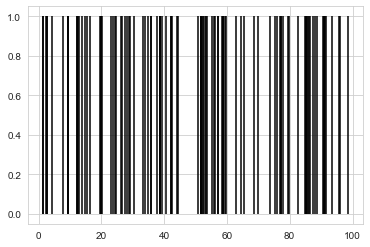

In [27]:
plt.figure()
plt.vlines(id_train[0].arrival_times.numpy(), ymin=0, ymax=1)
plt.show()

In [5]:
# Empirical distribution of each test statistic on id_train.
# This approximates the CDF of the test statistic under H_0
# and is used to compute the p-values
ecdfs = {}

for stat in test_statistics:
    name = stat.__name__
    scores = stat(poisson_times_per_mark=id_train_poisson_times)
    ecdfs[name] = ECDF(scores) # 経験分布関数はIn-sampleのデータ（定常ポアソン過程に変換）を使用

def twosided_pval(stat_name: str, scores: np.ndarray):
    """Compute two-sided p-value for the given values of test statistic.
    
    Args:
        stat_name: Name of the test statistic, 
            {"ks_arrival", "ks_interevent", "chi_squared", "sum_of_squared_spacings"}
        scores: Value of the statistic for each sample in the test set,
            shape [num_test_samples]
    
    Returns:
        p_vals: Two-sided p-value for each sample in the test set,
            shape [num_test_samples]
    """
    ecdf = ecdfs[stat_name](scores) # 事前計算したECDFに統計量を入力、両側検定量を得る
    return 2 * np.minimum(ecdf, 1 - ecdf)

In [32]:
ecdfs['ks_arrival'](0.5)

0.054

### Compute test statistic for ID test sequences

In [6]:
# ID test sequences will be compared to OOD test sequences to evaluate different test statistics
id_test = scenarios[0].sample_id(num_sequences)
id_test_batch = tpp.data.Batch.from_list(id_test)
id_test_poisson_times = tpp.utils.extract_poisson_arrival_times(model, id_test_batch)

# Compute the statistics for all ID test sequences
id_test_scores = {}
for stat in test_statistics:
    name = stat.__name__
    id_test_scores[name] = stat(poisson_times_per_mark=id_test_poisson_times)

### Compute test statistic for OOD test sequences & evaluate AUC ROC based on the p-values

In [7]:
results = []

detectability_values = np.arange(0, 0.95, step=0.05) # ここでdetactabilityといっているのは、OOD点過程のパラメータ
num_seeds = 5
for seed in trange(num_seeds):
    for scenario in tqdm(scenarios):
        for det in detectability_values:
            np.random.seed(seed)
            ood_test = scenario.sample_ood(num_sequences=num_sequences, detectability=det)
            ood_test_batch = tpp.data.Batch.from_list(ood_test)
            ood_poisson_times_per_mark = tpp.utils.extract_poisson_arrival_times(model, ood_test_batch)

            for stat in test_statistics:
                stat_name = stat.__name__
                id_scores = id_test_scores[stat_name]
                id_pvals = twosided_pval(stat_name, id_scores)

                ood_scores = stat(poisson_times_per_mark=ood_poisson_times_per_mark)
                ood_pvals = twosided_pval(stat_name, ood_scores)
                
                auc = tpp.utils.roc_auc_from_pvals(id_pvals, ood_pvals)

                res = {"statistic": stat_name, "seed": seed, "detectability": det, 
                       "auc": auc, "scenario": scenario.name}
                results.append(res)

In [8]:
df = pd.DataFrame(results)

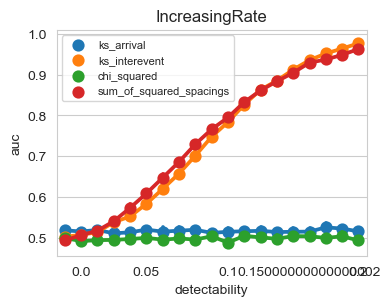

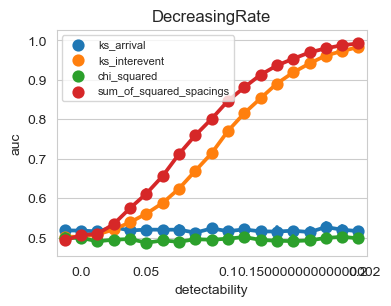

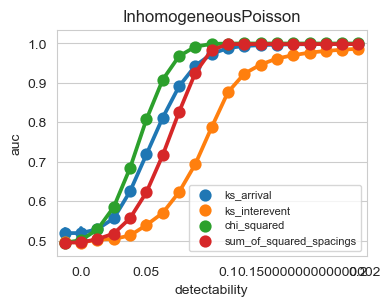

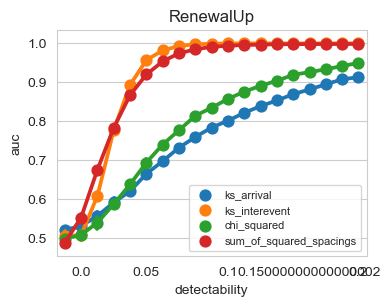

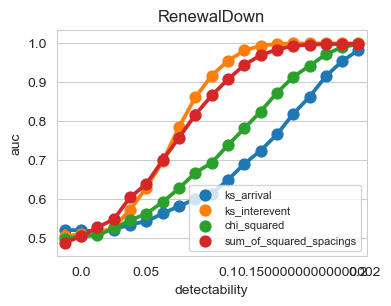

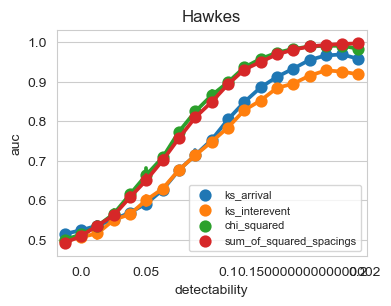

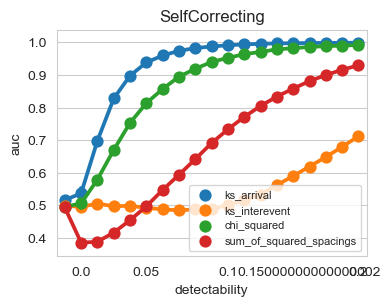

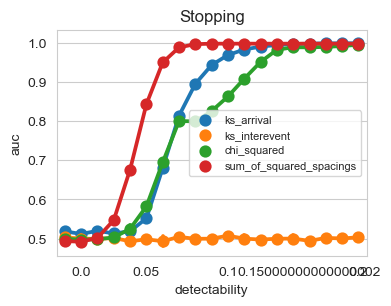

In [9]:
for scen in df.scenario.unique():
    plt.figure(figsize=[4, 3], dpi=100)
    df_sub = df[df.scenario == scen]
    sns.pointplot(data=df_sub, x="detectability", y="auc", hue="statistic")
    ax = plt.gca()
    ax.set_xticks([1, 5, 10, 15, 18])
    ax.set_title(scen)
    plt.legend(fontsize=8)
    plt.show()